## Part1. Basic image processing

In [1]:
# pillow - handling images install
# !pip install pillow

### Importing

In [2]:
import os
from PIL import Image

In [1]:
import torch
import torch.nn as nn # definng neural network
import torch.nn.functional as F # helper
from torch.utils.data import DataLoader # batching
from torchvision import datasets, transforms # loading datasets
from torchvision.utils import make_grid #for visualization
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [5]:
from IPython.display import display

### Basic Image Opening

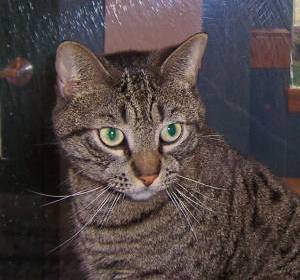

(280, 300, 3)


In [7]:
with Image.open('data/cat_dog/train/cat/1.jpg') as my_cat:
    display(my_cat)
    nparray_cat = np.array (my_cat)
    print (nparray_cat.shape)

### How to loop through all the files in folder

In [13]:
path      = 'data/cat_dog'
img_names = [] # get all the image names 

for folder, subfolders, filenames in os.walk(path):
    print(f"{folder} | {subfolders} | {filenames}")
    # print(filenames)
    # write whatever filtering you want - to get the file you want
    
    for name in filenames:
        img_names.append (folder + '/' + name)

data/cat_dog | ['test', 'train'] | ['.DS_Store']
data/cat_dog/test | ['cat', 'dog'] | ['.DS_Store']
data/cat_dog/test/cat | [] | ['9733.jpg', '10321.jpg', '11981.jpg', '10447.jpg', '11759.jpg', '12250.jpg', '9055.jpg', '12244.jpg', '9041.jpg', '11995.jpg', '10453.jpg', '10335.jpg', '9727.jpg', '11003.jpg', '9069.jpg', '11765.jpg', '11771.jpg', '12278.jpg', '11017.jpg', '10309.jpg', '9928.jpg', '9096.jpg', '12293.jpg', '11942.jpg', '10484.jpg', '11956.jpg', '10490.jpg', '9082.jpg', '12287.jpg', '9914.jpg', '9900.jpg', '9257.jpg', '12052.jpg', '10645.jpg', '10123.jpg', '9531.jpg', '9525.jpg', '10137.jpg', '11229.jpg', '10889.jpg', '10651.jpg', '9243.jpg', '12046.jpg', '11567.jpg', '10679.jpg', '11201.jpg', '11215.jpg', '9519.jpg', '11573.jpg', '10686.jpg', '11598.jpg', '12091.jpg', '9294.jpg', '12085.jpg', '9280.jpg', '10692.jpg', '10862.jpg', '10876.jpg', '12126.jpg', '9323.jpg', '10731.jpg', '11349.jpg', '10057.jpg', '9445.jpg', '9451.jpg', '10043.jpg', '10725.jpg', '12132.jpg', '9337.

In [17]:
# img_names
print(f"Total Images = ", {len(img_names)})

Total Images =  {25007}


### Transformation

- In deep learning for computer vision, we often transform our image as either 
    - (1) preprocessing step (or)
    - (2) for data augmentation

In [27]:
dog = Image.open('data/cat_dog/train/dog/14.jpg')
print(dog)
print(dog.size) # H = 500, w = 386
r,g,b = dog.getpixel((0,0)) # get the rgb values from(row,col) location
print(r,g,b) # this will be useful for filtering

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x386 at 0x116AD2450>
(500, 386)
89 97 100


torch.Size([3, 386, 500])


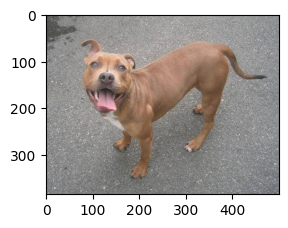

In [43]:
# np_dog = np.array(dog)
# np_dog.max()

# most basic transformation, which is making 0-255 to 0-1
transform = transforms.Compose([
    # transforms.Resize((50)), # height
    # transforms.Resize ((10,10)), # height and width
    # transforms.CenterCrop(150), # this is for data augmentation
    # transforms.FiveCrop (150),
    # transforms.RandomHorizontalFlip (p = 0.5),
    # transforms.RandomRotation (30),
    transforms.ToTensor()
])

# one, two, three, four, five = transform (dog) # five crop give 5 images

norm_dog = transform (dog)
print(norm_dog.shape)
type (norm_dog)

plt.figure (figsize = (3,3))
plt.imshow (np.transpose(norm_dog, (1,2,0)))
np_norm_dog = np.array (norm_dog)

In [35]:
print (f"mean = ", np_norm_dog.mean())
print (f"max  = ", np_norm_dog.max())

mean =  0.53362435
max  =  1.0


## Part2. 

### 2.1 Transformations

In [10]:
# online data argumentation - dynamically transform our image
# randomly during batching (through dataloader)

train_transform = transforms.Compose ([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.Resize (224),
    transforms.CenterCrop (224), # this will help focus on the faces
    transforms.ToTensor() # normalize
])

test_transform = transforms.Compose ([
    transforms.Resize (224),
    transforms.CenterCrop (224), # this will help focus on the faces
    transforms.ToTensor() # normalize
])

### 2.2 Load the data

In [12]:
root = 'data/cat_dog/'

train_data = datasets.ImageFolder(os.path.join(root,'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test'), transform = test_transform)

In [16]:
train_data[0][1]
print(f"train = ", len(train_data)) # we have 18002 images of train cat and dog
print(f"test = ", len(test_data)) # we have 6998 images of test cat and dog

18002
6998


In [27]:
# is there any imbalance ?
# train_data.samples
# train_data.targets
# set(train_data.targets)
np_targets = np.array (train_data.targets)
np_targets_test = np.array (test_data.targets)

In [24]:
len(np_targets[np_targets == 0]) # 9001 cats, 9001 dogs

9001

In [30]:
len(np_targets_test[np_targets_test == 0]) # 3499 cats and 3499 dogs

3499

### 2.3 Dataloaders

In [31]:
len(test_data)

6998

In [33]:
torch.manual_seed(3434343434)

train_loader = DataLoader (train_data, batch_size = 64, shuffle   = True)
test_loader  = DataLoader (test_data, batch_size  = 6998, shuffle = False)

In [35]:
for image, label in train_loader:
    print (image.shape) # (bs, ch, h, w)
    print (label.shape) # (bs,)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


### 2.4 Define our network

In [37]:
image.shape # (bs, ch, h, w)

torch.Size([64, 3, 224, 224])

In [36]:
l1  = nn.Conv2d (3, 6, 3, 1, 1) # (in_c, out_c, k, s, p)
l2  = nn.Conv2d (6, 16, 3, 1,1 )

l2(l1(image)).shape

torch.Size([64, 16, 224, 224])

In [40]:
class chaky_cnn (nn.Module):
    def __init__(self):
        super().__init__()
        self.l1  = nn.Conv2d (3, 6, 3, 1, 1) # (in_c, out_c, k, s, p)
        self.l2  = nn.Conv2d (6, 16, 3, 1, 1 )
        self.fc1 = nn.Linear (16 * 224 * 224, 120) # get from torch.size
        self.fc2 = nn.Linear (120, 84)
        self.fc3 = nn.Linear (84, 2)
        
    def forward (self, image):
        # shape of image = (64, 3, 224, 224)
        out = F.relu(self.l1(image))     # shape of out = (64, 6, 224, 224)
        out = F.relu(self.l2(out))       # shape of out = (64, 16, 224, 334)
        out = out.reshape ((-1, 16 * 224 * 224))
        out = F.relu (self.fc1(out))
        out = F.relu (self.fc2(out))
        out = F.relu (self.fc3(out))
        return out

In [44]:
# test case
model = chaky_cnn()
out   = model (image)
# out.shape [64,2]
assert out.shape[1] == 2

### 2.5 Loss and optimizer

In [49]:
criterion = nn.CrossEntropyLoss()
# optim     = torch.optim.Adam(model.parameters(), lr = 0.001)
optim     = torch.optim.SGD(model.parameters(), lr = 0.001)

### 2.6 Training

In [54]:
num_epochs = 5
    
for i in range(num_epochs):
    train_correct = 0
    for images, labels in train_loader:
        # image.to(device) # for GPU
        # labels.to (device) # for GPU
        y_hat = model(images) # shape y = (bs, probability of each classes)
        loss = criterion (y_hat, labels)
        
        real_pred = torch.max (y_hat, 1)[1] # return 2 output| [2] = index
        # print (real_pred)
        # print (real_pred == labels)
        train_correct += (real_pred == labels).sum()/images.shape[0] * 100
        # print (f"Train acc: {train_acc:.3f} | Loss: {loss.item():.3f}")
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    print(f"Epoch: {i} | Train acc: {train_correct/len(train_loader):3.2f} | Loss: {loss.item():3.4f}")

Epoch: 0 | Train acc: 50.00 | Loss: 0.6931
Epoch: 1 | Train acc: 50.00 | Loss: 0.6931
Epoch: 2 | Train acc: 49.99 | Loss: 0.6931
Epoch: 3 | Train acc: 50.00 | Loss: 0.6931
Epoch: 4 | Train acc: 49.94 | Loss: 0.6931


### 2.7 Inference

In [55]:
# random sample
some_sample_image = test_data[44][0]
some_sample_image.shape

torch.Size([3, 224, 224])

In [56]:
output = model (some_sample_image)
output

tensor([[0., 0.]], grad_fn=<ReluBackward0>)

In [57]:
# predict the random sample
torch.max(output, 1)[1]
train_data.classes

['cat', 'dog']

In [58]:
# check the acutal data
test_data[44][1]

0

In [ ]:
# stop here

## Part3. Using pretrained models

In [ ]:
from torchvision.models import models # actually pretrained models are offered by many vendors

In [ ]:
alexnet = models.alexnet (weights = models.AlexNet_Weights.DEFAULT)
# alexnet

In [ ]:
# freeze the parameters
# you don't need to train the parameters
for param in alexnet.parameter():
    param.requires_grad = False # you don't allow any parameter in AlexNet to learn

In [ ]:
alexnet.classifier = nn.Sequential(
    nn.Linear (in_features = 9216, out_features = 1024),
    nn.RELU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 2)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(alexnet.parameters(), lr = 0.001)

In [ ]:
# training
num_epochs = 5
    
for i in range(num_epochs):
    train_correct = 0
    
    for images, labels in train_loader:
        # image.to(device) # for GPU
        # labels.to (device) # for GPU
        y_hat = alexnet(images) # yhat: (bs, classes)
        loss = criterion (y_hat, labels)
        
        real_pred = torch.max (y_hat, 1)[1] # return 2 output| [2] = index
        # print (real_pred)
        # print (real_pred == labels)
        train_correct += (real_pred == labels).sum()/images.shape[0] * 100
        # print (f"Train acc: {train_acc:.3f} | Loss: {loss.item():.3f}")
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    print(f"Epoch: {i} | Train acc: {train_correct/len(train_loader):3.2f} | Loss: {loss.item():3.4f}")